In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# modflow utility
import flopy
import flopy.utils.binaryfile as bf


In [2]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = os.path.dirname(git_dir)
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'
# permeameter analysis
# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning' # no conditioning data

# tprogs_id = 'north_shifted_stream_distance_analysis'

# connec3d analysis
tprogs_id = '_no_cond_c3d' # no conditioning data



data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'


In [4]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
    
loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
# model_ws = loadpth+'Permeameter_for_velocity' + tprogs_id
model_ws = loadpth+'Permeameter_for_velocity' 

load_only = ['DIS','OC']
name = 'MF.nam'
# name = 'MF_child.nam'
m = flopy.modflow.Modflow.load(name, model_ws=model_ws, load_only = load_only,
                                exe_name='mf2005', version='mf2005')


KeyboardInterrupt: 

In [5]:

def plt_hf_cum_area(hf_tot_df, percentile, label,ax):
    ''' percentiles available are 87, 95 and 99th '''
#     fig,ax = plt.subplots(figsize=(8,4))
    hf_tot_df = hf_tot_df.transpose()
    # convert to hectares from m2
    hf_tot_df = hf_tot_df.multiply(1E-4)
    hf_tot_df.index = hf_tot_df.index.astype(int)
    hf_max = hf_tot_df.max().max()
    hf_tot_df.plot(color='lightgray',ax=ax, legend=False)
    hf_tot_df.mean(axis=1).plot(legend=False, ax=ax, color='black', label='Realizations Averaged') #colormap='gray',
    
    ax.set_xlabel('Setback Distance (m)')
    ax.set_ylabel('Cumulative Area  (ha)')
#     plt.title(label)
#     ax.set_title(str(percentile)+'th percentile of Flow')
    plt.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
    plt.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
#     plt.savefig(fig_dir+'high_flow_cells_by_distance_'+label+'_'+str(percentile)+'.png',dpi=600)
    # plt.legend(ncol = 4, loc = (1.05, 0.05))
    


In [9]:
# percentile = 95
percentile = 6


label='regional'
hf_tot_df = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')


In [10]:

# label='local'
# # each set of 100 rows is a different location
# hf_tot_df_local = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')
# # join local and regional datasets
# hf_all = hf_tot_df.append(hf_tot_df_local)
# site_order = ['Regional','Blodgett','Mahon','Oneto-Denier']

hf_all = hf_tot_df.copy()
site_order = ['Regional']

# # create clean index for easier referencing
site_realization = np.vstack((np.repeat(site_order,100),
                              np.tile(np.arange(1,101),int(hf_all.shape[0]/100))))
site_realization_index = pd.MultiIndex.from_arrays(site_realization,names=['Site','Realization'])

hf_all = hf_all.set_index(site_realization_index)

# convert from number of cells to area, m^2
hf_all.loc[:] = hf_all.values*200*200
# plot with setback as x and realizations as label
hf_all.columns = pd.to_numeric(hf_all.columns)

In [12]:
def plt_hf_step_area(hf_tot_df, percentile, label,ax):
    ''' percentiles available are 87, 95 and 99th '''
#     fig,ax = plt.subplots(figsize=(8,4))
    hf_tot_df = hf_tot_df.transpose()
    # convert to hectares from m2
    hf_tot_df = hf_tot_df.multiply(1E-4)
    hf_tot_df.index = hf_tot_df.index.astype(int)

    hf_diff = hf_tot_df.diff(axis=0)
    hf_diff.iloc[0,:] = 0
    hf_max = hf_diff.max().max()
    hf_diff.plot(legend=False, ax=ax,
                 color='lightgray', #colormap='gray',
                )
    hf_diff.mean(axis=1).plot(legend=False, ax=ax, color='black', label='Realizations Averaged') 

    ax.set_xlabel('Setback Distance (m)')
    ax.set_ylabel('Area (ha)')
#     ax.set_title(str(percentile)+'th percentile of Flow')
    ax.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
    ax.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
    fig.tight_layout()
#     plt.savefig(fig_dir+'high_flow_cells_diff_by_distance_'+str(percentile)+'.png',dpi=600)
    


In [ ]:

# hf_all.loc[n].transpose().plot(legend=False, colormap='gray')
# plt.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')


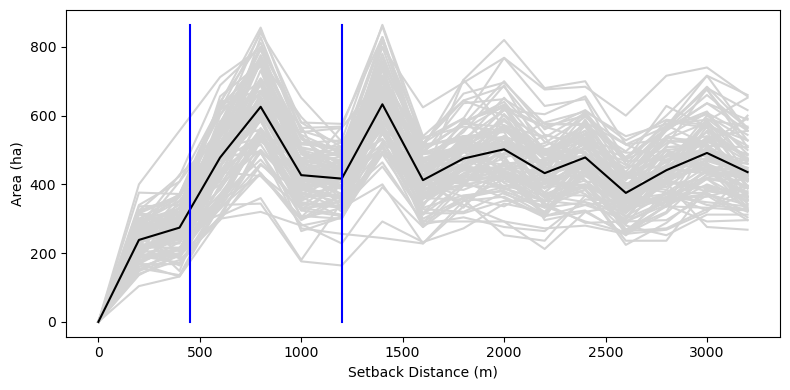

In [16]:
fig,ax=plt.subplots(figsize=(8,4))
plt_hf_step_area(hf_all.loc['Regional'],percentile, 'regional',ax)

# plt.savefig(fig_dir+'high_flow_cells_diff_by_distance_regional_'+str(percentile)+'.png',dpi=600)

# fig,ax=plt.subplots()
# plt_hf_cum_area(hf_all.loc['Regional'], percentile, 'regional',ax[1])

In [27]:
# plot all of these to show initial reaction that on a regional scale all realizations provide high recharge area,
# but local scale these signals are more variable and have more obvious asymptotes
# fig,ax=plt.subplots(2,2,figsize=(12,12),sharex=True, sharey=False)
# for i,n in enumerate(site_order):
#     ax_n = ax[int(i/2), i % 2]
#     df = hf_all.multiply(1E-4).loc[n]
#     df.transpose().plot(legend=False, ax=ax_n, color='lightgray') #colormap='gray',
#     df.transpose().mean(axis=1).plot(legend=False, ax=ax_n, color='black', label='Realizations Averaged') #colormap='gray',

#     # plot min, median and max, median doesn't match up so doesn't plot
#     df[df.mean(axis=1).isin(df.mean(axis=1).quantile([0,0.5,1]).values)].transpose().plot(legend=False, ax=ax_n, color='red')
#     ax_n.set_title(n)
# #     hf_max = df.max().max()
# #     ax_n.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
# #     ax_n.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
# #     plt_hf_cum_area(hf_all.loc[n],percentile,n, ax[i])

# fig.text(-0.02,0.4,'Cumulative Area of High Flow Cells (hectares)',rotation=90, fontdict={'size':18}) 
# fig.text(0.4,-0.03,'Setback distance (m)',  fontdict={'size':18})

# #($m^2$)
# fig.tight_layout()
# plt.savefig(fig_dir+'all_sites_high_flow_cells_diff_by_distance_'+str(percentile)+'.png',dpi=600)

# plt_hf_cum_area(hf_all.loc['Regional'],percentile, 'regional')
# plt_hf_cum_area(hf_all.loc['Blodgett'], percentile, 'local')
# plt_hf_cum_area(hf_all.loc['Mahon'], percentile, 'local')
# plt_hf_cum_area(hf_all.loc['Oneto-Denier'], percentile, 'local')

Plot overlay of high flow cells to see where TPROGs might be heavily identifying recharge spots.

In [18]:
# flow_percentile=95
hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, 100, 230))

In [ ]:

# fig,ax = plt.subplots(figsize=(8, 8))
# # im = ax.imshow(hf_tot.sum(axis=0))
# # plt.colorbar(im, shrink = 0.6)

# mapview = flopy.plot.PlotMapView(model=m,ax=ax)
# im = mapview.plot_array(hf_tot.sum(axis=0))
# cb = plt.colorbar(im, shrink=0.75,ax=ax)
# # cb.set_label('Horiz. Cond. (m/d)')
# fig.text(0.2, 0.9, 'Number high recharge cells\n across all realizations', fontdict={'size':18})
# plt.xlabel('Easting (m)')
# plt.ylabel('Northing (m)')
# ax.ticklabel_format(style='plain')


In [11]:
offset = hf_all.loc['Blodgett'].loc[:,[400,600,800]] - hf_all.loc['Blodgett'].loc[:,[400,600,800]].mean(axis=0)
offset = offset.where(offset == np.min(np.abs(offset)))
offset.loc[:,400]

Realization
1      5600.0
2         NaN
3         NaN
4         NaN
5         NaN
        ...  
96        NaN
97        NaN
98        NaN
99        NaN
100       NaN
Name: 400, Length: 100, dtype: float64

In [12]:
def best_match_realization(offset,param):
    offset = offset.where(offset == np.min(np.abs(offset)))
    closest_means = offset.melt(ignore_index=False).dropna()
    # closest_means.variable.plot(kind='bar', stacked=True)
    most_vals = pd.Series(closest_means.index).value_counts()
    realization = most_vals.sort_values(ascending=False).index[0]
    print('Realization ', realization, ' is closest to the ',param)
    
# realization 90 is closest to the mean for both 600,800 meter setback
dists = np.arange(400,1200,200)
offset = hf_all.loc['Blodgett'].loc[:,dists] - hf_all.loc['Blodgett'].loc[:,dists].mean(axis=0)
best_match_realization(offset,'mean')

offset = hf_all.loc['Blodgett'].loc[:,dists] - hf_all.loc['Blodgett'].loc[:,dists].max(axis=0)
best_match_realization(offset,'max')

offset = hf_all.loc['Blodgett'].loc[:,dists] - hf_all.loc['Blodgett'].loc[:,dists].min(axis=0)
best_match_realization(offset,'min')

Realization  18  is closest to the  mean
Realization  73  is closest to the  max
Realization  98  is closest to the  min


The spread of results generally shows increasing returns for greater setback, however there is a tipping point near the mean lengths values after which maximum gains are found so setback should be slightly greater than the mean lengths in both horizontal directions. An interesting follow up analysis would be the total recharge achieved by high flow cells as a way of understanding what is needed.

In [13]:
# this figure works on the regional scale, but doesn't represent much on the local scale
# plt_hf_step_area(hf_all.loc['Regional'],percentile, 'regional')
# plt_hf_step_area(hf_all.loc['Blodgett'], percentile, 'local')
# plt_hf_step_area(hf_all.loc['Mahon'], percentile, 'local')
# plt_hf_step_area(hf_all.loc['Oneto-Denier'], percentile, 'local')


In [14]:
def plt_hf_stddev(hf_tot_df, percentile, label):
    ''' percentiles available are 87, 95 and 99th '''
    hf_tot_df = hf_tot_df.transpose()*200*200
    hf_tot_df.index = hf_tot_df.index.astype(int)
    # calculate variance in recharge area between realizations
    stddev = hf_tot_df.std(axis=1)
    stddev.plot(colormap='gray',ax=ax, legend=False, label=label)

    plt.xlabel('Setback Distance (m)')
    ax.set_ylabel('Standard Deviation of Cumulative Area \nof High Flow Cells($m^2$)')

    plt.title('Vertical Flow ' + str(percentile)+'th percentile Cells Among 100 Realizations')
    fig.tight_layout()

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_50268\2221438977.py:9: DeprecationWarning: invalid escape sequence \s
  ax.set_ylabel('Coeff. of Variation ($ \\frac{\sigma}{\mu} $) of Cumulative Area \nof High Flow Cells ($m^2$)', size=14)


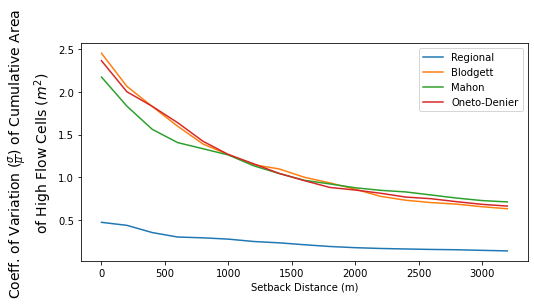

In [15]:
fig,ax = plt.subplots(figsize=(8,4))

# for n in hf_all.index.levels[0]:
#     hf_all.loc[n].std(axis=0).plot(label=n,ax=ax)
# ax.set_ylabel('Standard Deviation of Cumulative Area \nof High Flow Cells Within Setback ($m^2$)')
#hf_all.index.levels[0], reference sites from
for n in site_order:
    (hf_all.loc[n].std(axis=0)/hf_all.loc[n].mean(axis=0)).plot(label=n,ax=ax)
ax.set_ylabel('Coeff. of Variation ($ \\frac{\sigma}{\mu} $) of Cumulative Area \nof High Flow Cells ($m^2$)', size=14)

plt.xlabel('Setback Distance (m)')
plt.legend()
plt.savefig(fig_dir+'all_sites_coeff_variation_by_distance_'+str(percentile)+'.png',dpi=600)


The coefficient of variation demonstrates that the local scale setbacks have a higher relative standard deviation between
realizations than on a regional scale. The regional scale show a near constant coefficient of variation and the 3 local sites have similar patterns, reducing variability toward larger setback distances.

## Optimal gradient 

Gaussian filters serve to reduce noise and detail in datasets. They can aid in edge detection in imagery because the noise surrounding contours is reduced. In this case, it reduces detail between setback distances but overall allows a clearer picture of the trend.

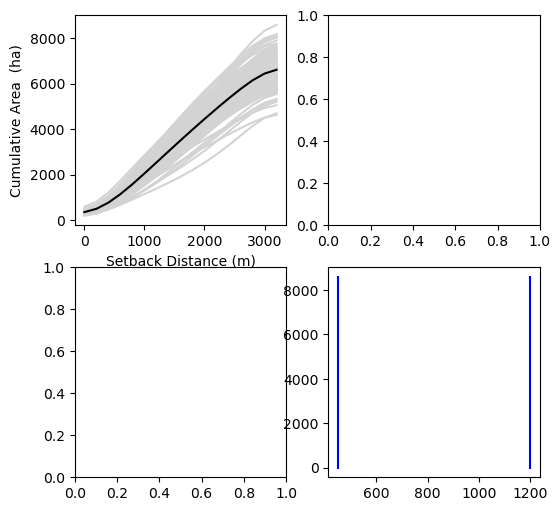

In [17]:
# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
# smooth across setback distances so the changes in high flow area are less abrupt, makes it easier to find gradients
smooth = gaussian_filter1d(hf_all,2)

smooth = pd.DataFrame(smooth, index=site_realization_index,columns=np.arange(0,3400,200))
# smooth
# plt_hf_cum_area(hf_all.loc['Regional'], percentile,'Regional')
fig,ax=plt.subplots(2,2,figsize=(6,6))
for i,n in enumerate(site_order):
    ax_n = ax[int(i/2), i % 2]
    plt_hf_cum_area(smooth.loc[n], percentile,n,ax=ax_n)
# ax.set_ylabel('Smoothed Cumulative Area \nof High Flow Cells ($m^2$)')


Text(0, 0.5, 'Realizations with a maximum gradient')

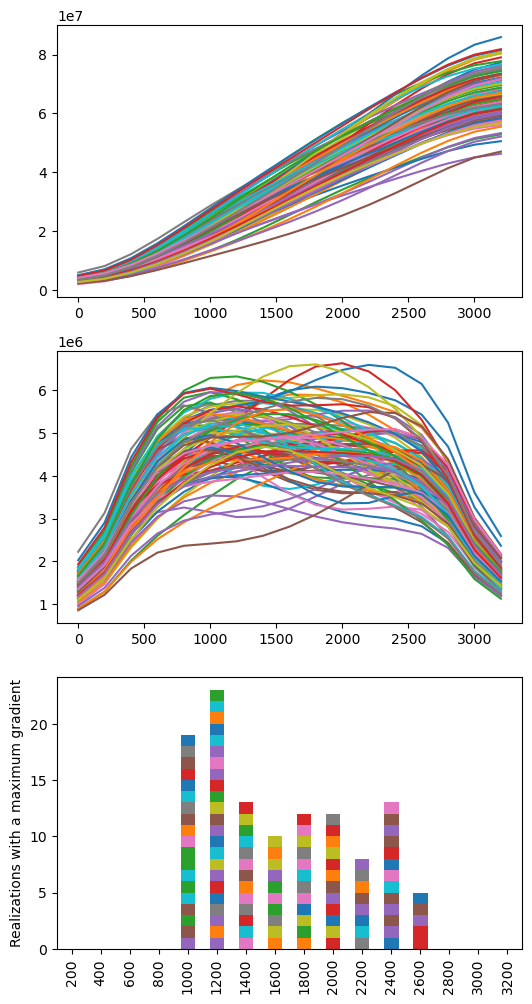

In [18]:
n='Regional'
r = np.arange(1,100).astype(str)
# can look at maximum of first derivative, or look where second derivative goes from + to -
grad1_df = pd.DataFrame(np.gradient(smooth)[1], index=site_realization_index, columns = np.arange(0,3400,200))
# plt_hf_cum_area(grad1_df.loc[n].loc[r], percentile, n)

grad2_df = pd.DataFrame(np.gradient(grad1_df)[1], index=site_realization_index, columns = np.arange(0,3400,200))
# # grad2_df
# plt_hf_cum_area(grad2_df.loc[n], percentile, n)
# find switching points
plt.show()
fig,ax=plt.subplots(3,1,figsize=(6,12))
smooth.loc[n].loc[r].transpose().plot(legend=False,ax=ax[0])
plt.ylabel('High K area smoothed with setbacks')

grad1_df.loc[n].loc[r].transpose().plot(legend=False,ax=ax[1])
plt.ylabel('First derivative of High K area')

# plt.legend(ncol=5,loc=(1.2,0.2))
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
max_df = pd.DataFrame(np.diff(np.sign(grad2_df)), index=site_realization_index,columns = np.arange(200,3400,200))
max_df = 1*(max_df==-2)
max_df.loc[n].loc[r].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax[2])
plt.ylabel('Realizations with a maximum gradient')
# fig.tight_layout()


Grad1 max:  9


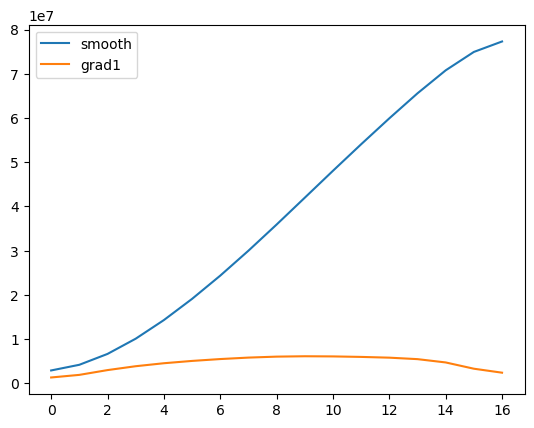

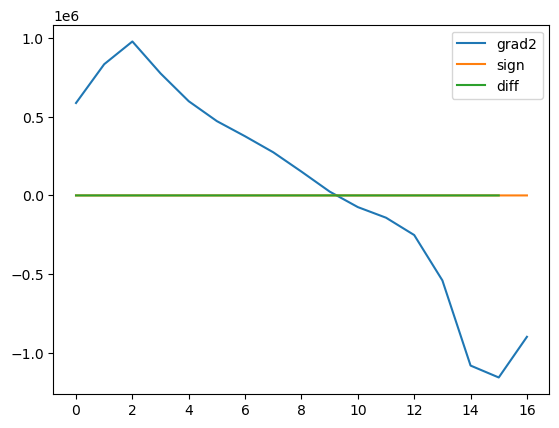

In [25]:
#example of how g
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
grad1_max = np.where(np.diff(np.sign(grad2_df))==-2)

r = 20
plt.plot(smooth.values[r,:],label='smooth')

plt.plot(grad1_df.values[r,:],label='grad1')
plt.legend()
print('Grad1 max: ',grad1_df.values[r,:].argmax())
plt.show()
plt.plot(grad2_df.values[r,:],label='grad2')

plt.plot(np.sign(grad2_df).values[r,:],label='sign')
plt.plot(np.diff(np.sign(grad2_df))[r,:],label='diff')
plt.legend()

# Plot Smooth, 1st Derivative, Maxima

In [30]:
max_df_plt = max_df.loc['Regional'].transpose()
max_df_plt.index

Int64Index([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200,
            2400, 2600, 2800, 3000, 3200],
           dtype='int64')

Text(0, 0.5, 'Maximum gradient count\nby realization')

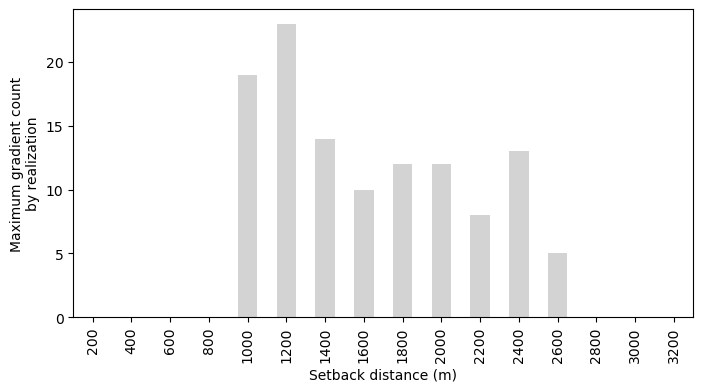

In [31]:
fig,ax=plt.subplots(figsize=(8,4))
max_df.loc['Regional'].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax, color='lightgray') 

# fig.text(-0.01, 0.2,'Number of realizations with a \nmaximum gradient at the setback',rotation=90, fontdict={'size':18})

# fig.text(-0.01, 0.2,'Maximum gradient count\nby realization',rotation=90, fontdict={'size':14})
# fig.text(0.4, -.1,'Setback distance (m)',  fontdict={'size':14})
plt.xlabel('Setback distance (m)')
plt.ylabel('Maximum gradient count\nby realization')
# plt.xlim(0,3200)

Text(0.4, 0.03, 'Setback distance (m)')

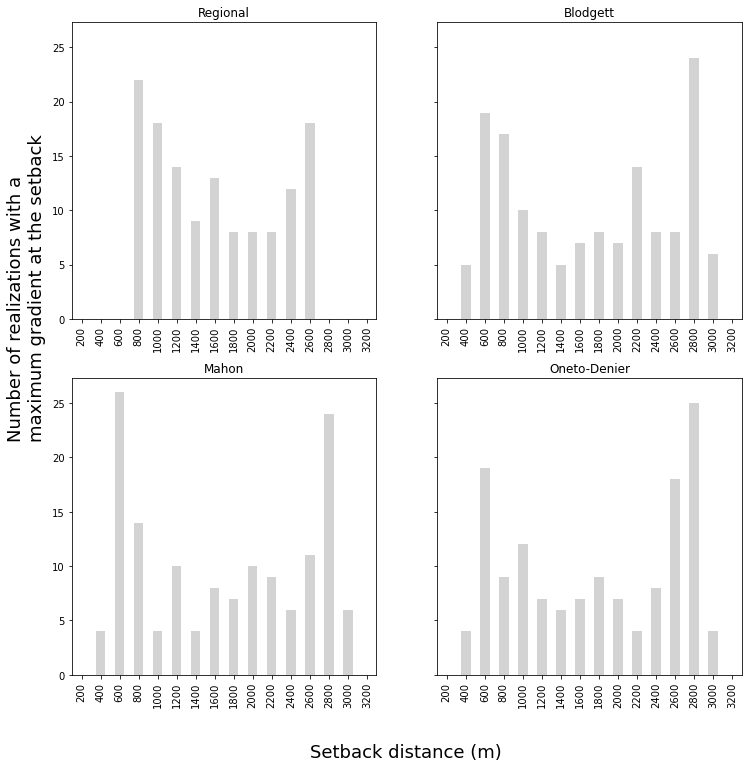

In [30]:
fig,ax=plt.subplots(2,2,figsize=(12,12),sharex=False, sharey=True)
for i,n in enumerate(site_order):
    #.loc[r]
    ax_n = ax[int(i/2), (i % 2)]
    max_df.loc[n].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax_n, color='lightgray') # colormap='gray'
    ax_n.set_title(n)
fig.text(0.05,0.4,'Number of realizations with a \nmaximum gradient at the setback',rotation=90, fontdict={'size':18})
fig.text(0.4,0.03,'Setback distance (m)',  fontdict={'size':18})

# plt.savefig()
# plt.savefig(fig_dir+'all_sites_max_gradient_by_distance_'+str(percentile)+'.png',dpi=600)


## High K Cell Group Area statistics 

In [38]:
def stats_cell2area(df):
    ''' convert cell count stats to areas'''
    df.Mean *= 200**2
    df.Max *= 200**2
    df.Min *= 200**2
    df.Median *= 200**2
    df.Setback *= 200
#     df = df.set_index('Realization')
    return(df)

cell_stats_all=pd.read_csv(data_dir+'surface_highflow_cells_statistics_regional'+str(percentile)+'.csv')
cell_stats_all = stats_cell2area(cell_stats_all)
cell_stats_all['Location'] = 0
cell_stats_all['Site'] = 'Regional'
# 1:BLodgett, 2:Mahon, 3:Oneto-Denier
# site_dict = {1:'Blodgett',2:'Mahon',3:'Oneto-Denier'}
# cell_stats_all_local = pd.read_csv(data_dir+'surface_highflow_cells_statistics_local'+str(percentile)+'.csv')
# cell_stats_all_local = stats_cell2area(cell_stats_all_local)
# cell_stats_all_local['Site'] = list(site_dict[k] for k in cell_stats_all_local.Location.values)

# cell_stats_all = cell_stats_all.append(cell_stats_all_local)
cell_stats_all = cell_stats_all.set_index(['Site','Realization'])
cell_stats_all['Mean_Num_Grps'] = cell_stats_all.Mean/cell_stats_all.Num_Grps


<AxesSubplot:xlabel='Setback'>

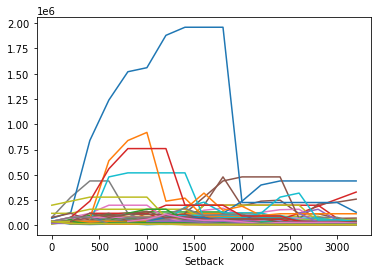

In [32]:
n='Oneto-Denier'
cell_stats_all.loc[n].pivot_table(columns='Realization',values='Mean_Num_Grps',index='Setback').plot(legend=False)

A high number of groups with small mean areas suggests there is no one best place generally to place setbacks, while if the number of groups is small with large mean areas then it is worthwhile creating focused setback.
Compare number of groups to mean area: doesn't seem to be a clear pattern in the mean area divided by the number of groups on a local scale, on a regional scale area divided by number of groups decreases with setback probably because as seback increases there are more small groups but not as many large groups. It could be on a local scale each realiztaion has significantly different outcrops so how it happens isn't regular unless you have geophysical data. This approach can't approximate best locations, only best distances based on cumulated high K area.

Text(0, 0.5, 'Number of High Flow Area Groups')

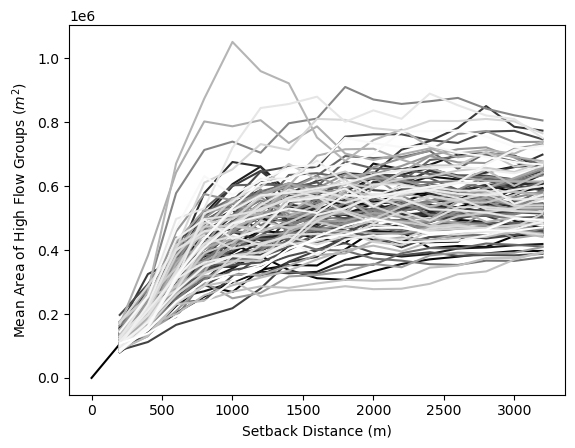

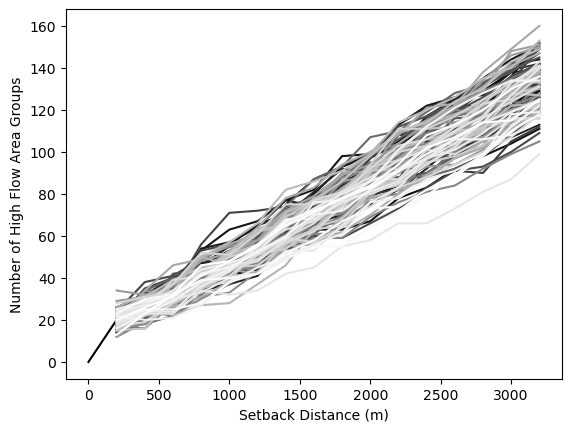

In [39]:
# pd.DataFrame(cell_stats_all_local.loc[:,'Max'])
param='Max'
def plt_cell_stats(df, param):
    df = df.loc[:,[param,'Setback']].pivot_table(values=param, columns='Realization', index='Setback')
    df.plot(colormap='gray', legend=False)
    plt.ylabel(param+' Area of High Flow Groups ($m^2$)')
    plt.xlabel('Setback Distance (m)')
    
    
# plt_cell_stats(cell_stats_all,'Max')
n='Regional'
plt_cell_stats(cell_stats_all.loc[n],'Mean')

plt_cell_stats(cell_stats_all.loc[n],'Num_Grps')
plt.ylabel('Number of High Flow Area Groups')